<a href="https://colab.research.google.com/github/lolobq/ECGR-5106-Intro_To_Deep_Learning/blob/main/Homework1/DeepLearningHomework1Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Problem 1a

Develop a multi-layer perceptron with three hidden layers (you pick the dimensions of the hidden layers) for the CIFAR-10 dataset. Train the model from scratch (with randomized parameters) and plot the results (training loss and accuracy, validation accuracy) after 20 epochs. Does your network need more epochs for full training? Do you observe overfitting? Make sure to save the trained parameters and model. Report and plot your training and validation results. Report precision, recall, F1 score, and confusion matrix.

In [2]:
# Load CIFAR-10 dataset to calculate mean and std
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformation with calculated mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load CIFAR-10 dataset with normalization
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 512)  # Image size is 32 by 32 with 3 channels for RGB
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 10) # 10 output classes in CIFAR-10

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the model
model = CIFAR10Net().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 20
loss_values = []
training_accuracy = []
validation_accuracy = []
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    training_correct = 0
    training_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        training_total += labels.size(0)
        training_correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    loss_values.append(running_loss / len(train_loader))
    training_accuracy.append(training_correct / training_total)

    # Print training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Training Time: {training_time:.2f} seconds')

    # Print total training time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f'Total Training Time: {total_training_time:.2f} seconds')

    # Testing the model
    model.eval()
    val_correct = 0
    val_total = 0
    all_predicted = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Update validation accuracy
    validation_accuracy.append(val_correct / val_total)

    # Set the model back to training mode
    model.train()

100%|██████████| 170498071/170498071 [00:03<00:00, 43287831.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 2.067704648617893, Training Time: 12.78 seconds
Total Training Time: 12.78 seconds
Epoch 2/20, Loss: 1.7305358347990323, Training Time: 11.95 seconds
Total Training Time: 27.09 seconds
Epoch 3/20, Loss: 1.587831711372756, Training Time: 11.87 seconds
Total Training Time: 41.06 seconds
Epoch 4/20, Loss: 1.4907755366981488, Training Time: 12.09 seconds
Total Training Time: 55.22 seconds
Epoch 5/20, Loss: 1.4118089628646442, Training Time: 12.09 seconds
Total Training Time: 69.50 seconds
Epoch 6/20, Loss: 1.345220052372769, Training Time: 12.90 seconds
Total Training Time: 84.88 seconds
Epoch 7/20, Loss: 1.2891180692883708, Training Time: 11.84 seconds
Total Training Time: 98.78 seconds
Epoch 8/20, Loss: 1.2358126481018408, Training Time: 12.05 seconds
Total Training Time: 112.89 seconds
Epoch 9/20, Loss: 1.1893548158276113, Training Time: 12.47 

Final Training Loss: 0.7644303460483965


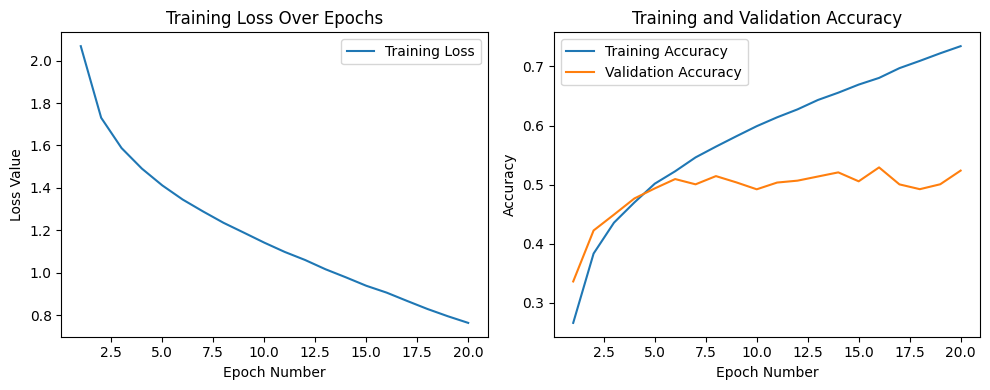

              precision    recall  f1-score   support

           0       0.64      0.57      0.61      1000
           1       0.66      0.60      0.62      1000
           2       0.42      0.48      0.45      1000
           3       0.36      0.31      0.33      1000
           4       0.48      0.38      0.42      1000
           5       0.40      0.51      0.45      1000
           6       0.72      0.41      0.52      1000
           7       0.53      0.65      0.58      1000
           8       0.59      0.72      0.65      1000
           9       0.54      0.61      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.52     10000
weighted avg       0.53      0.52      0.52     10000



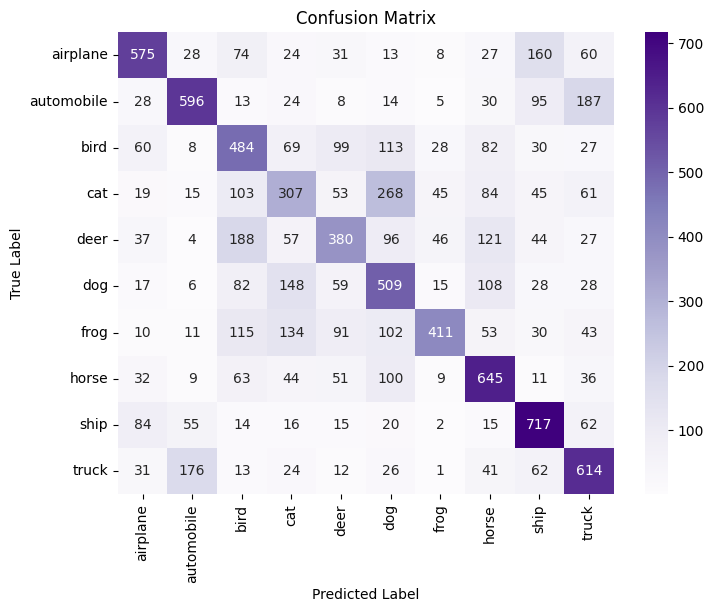

In [3]:
print(f'Final Training Loss: {loss_values[-1]}')
epochs_range = range(1, num_epochs + 1)

# Plot Training Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_values, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(true_labels, all_predicted)
report = classification_report(true_labels, all_predicted)
print(report)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Problem 1b

Explore the complexity of the network by increasing its width and depth. How do the training and validation results change? Compare them against the baseline. Do you see any overfitting?

In [4]:
# Load CIFAR-10 dataset to calculate mean and std
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformation with calculated mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load CIFAR-10 dataset with normalization
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class CIFAR10DeepNet(nn.Module):
    def __init__(self):
        super(CIFAR10DeepNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 1024)  # Image size is 32 by 32 with 3 channels for RGB
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 128) # 10 output classes in CIFAR-10
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.fc5(x)
        return x

# Instantiate the model
model = CIFAR10DeepNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 20
loss_values = []
training_accuracy = []
validation_accuracy = []
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    training_correct = 0
    training_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        training_total += labels.size(0)
        training_correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    loss_values.append(running_loss / len(train_loader))
    training_accuracy.append(training_correct / training_total)

    # Print training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Training Time: {training_time:.2f} seconds')

    # Print total training time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f'Total Training Time: {total_training_time:.2f} seconds')

    # Testing the model
    model.eval()
    val_correct = 0
    val_total = 0
    all_predicted = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Update validation accuracy
    validation_accuracy.append(val_correct / val_total)

    # Set the model back to training mode
    model.train()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 2.2198078292410086, Training Time: 12.70 seconds
Total Training Time: 12.70 seconds
Epoch 2/20, Loss: 1.8984211102471023, Training Time: 11.93 seconds
Total Training Time: 26.70 seconds
Epoch 3/20, Loss: 1.6964710673407826, Training Time: 12.04 seconds
Total Training Time: 40.87 seconds
Epoch 4/20, Loss: 1.569966603270577, Training Time: 12.02 seconds
Total Training Time: 55.67 seconds
Epoch 5/20, Loss: 1.4741209887177742, Training Time: 12.93 seconds
Total Training Time: 70.72 seconds
Epoch 6/20, Loss: 1.392719771246166, Training Time: 11.87 seconds
Total Training Time: 84.68 seconds
Epoch 7/20, Loss: 1.325299041807804, Training Time: 12.07 seconds
Total Training Time: 98.88 seconds
Epoch 8/20, Loss: 1.2663442601480752, Training Time: 11.96 seconds
Total Training Time: 113.05 seconds
Epoch 9/20, Loss: 1.20926948269005, Training Time: 11.88 seconds
Total T

Final Training Loss: 0.6996427907053467


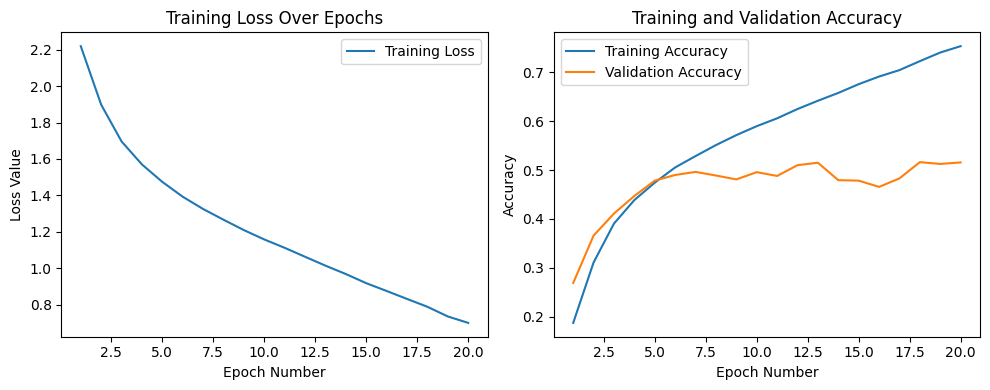

              precision    recall  f1-score   support

           0       0.57      0.70      0.63      1000
           1       0.68      0.61      0.64      1000
           2       0.46      0.38      0.41      1000
           3       0.36      0.29      0.32      1000
           4       0.55      0.35      0.43      1000
           5       0.27      0.61      0.37      1000
           6       0.64      0.44      0.52      1000
           7       0.70      0.56      0.62      1000
           8       0.71      0.65      0.68      1000
           9       0.62      0.59      0.60      1000

    accuracy                           0.52     10000
   macro avg       0.56      0.52      0.52     10000
weighted avg       0.56      0.52      0.52     10000



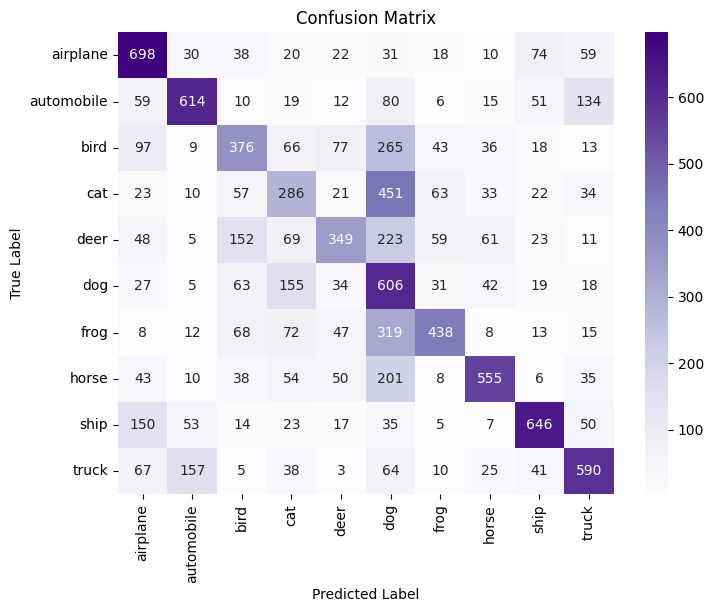

In [5]:
print(f'Final Training Loss: {loss_values[-1]}')
epochs_range = range(1, num_epochs + 1)

# Plot Training Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_values, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(true_labels, all_predicted)
report = classification_report(true_labels, all_predicted)
print(report)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()